In [1]:
import pandas as pd
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
len(df)

891

In [4]:
survivors = df.Survived.sum()
unsurvivors = len(df) - survivors
print(survivors)
print(unsurvivors)

342
549


## Data Check

In [5]:
print(df.isnull().sum())
print("----------")
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# Cabin null %
print(df.Cabin.isnull().sum()/len(df))
print(df_test.Cabin.isnull().sum()/len(df))


0.7710437710437711
0.367003367003367


In [7]:
# Almost 80% of the Cabin data is missing. That probably means only 20% of the passengers had a cabin.So dropping the column
df.drop('Cabin',axis = 1,inplace=True)
df_test.drop('Cabin',axis = 1,inplace=True)

In [8]:
#Age null %
df.Age.isnull().sum()/len(df)
df.Age.isnull().sum()/len(df)

0.19865319865319866

In [9]:
# 20% Age data is missing so we need to take mean value
df.Age = df.Age.fillna(df.Age.median())
df_test.Age = df_test.Age.fillna(df_test.Age.median())

In [10]:
df.drop('PassengerId', axis = 1, inplace = True)
df_test.drop('PassengerId', axis = 1, inplace = True)

## Feature Exploration

In [11]:
list_features = df_test.columns
for f in list_features:
    print(f, len(df[f].unique()))

Pclass 3
Name 891
Sex 2
Age 88
SibSp 7
Parch 7
Ticket 681
Fare 248
Embarked 4


## Data Analysis

Let's observe the survival of people following the categorical features.

In [12]:
df[['Pclass','Survived']].groupby('Pclass').mean().sort_values(by='Survived',ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [13]:
df[['Sex', 'Survived']].groupby('Sex').mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [14]:
df[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [15]:
df[['Embarked', 'Pclass']].groupby('Embarked').mean().sort_values(by='Pclass', ascending=False)

,Pclass
Embarked,
Q,2.909091
S,2.350932
C,1.886905


In [16]:
df[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [17]:
df[["Parch", "Survived"]].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


- Pclass and Sex has a great correlation with the survival of people -> Keep them as features
- SibSp & Parch require engineering.
- Embarked: I have some doubts on the correlation between survival and Embarked. I think the observed correlation is spurious and more due to third party factors (such as passenger class or sex). We'll need to try the model with/without this feature which will be encoded as one-hot.

## Feature engineering 

In [18]:
# Pclass modify
mapping_pclass = {1:1, 2:0, 3:-1}
df['Pclass'] = df['Pclass'].map(mapping_pclass)
df_test['Pclass'] = df_test['Pclass'].map(mapping_pclass)

In [19]:
# Take peoples title from their name
# This function takes as input the name and returns the title of the people.

def get_title(var):
    title = var.split(',')[1]
    title2 = title.split('.')[0]
    return title2[1:]

In [20]:
#create the title colmun

df['Title'] = df.apply(lambda x: get_title(x.Name), axis = 1)
df_test['Title'] = df_test.apply(lambda x: get_title(x.Name), axis = 1)

In [21]:
print(df.groupby('Title').count().sort_values(by='Survived', ascending=False)['Pclass'])
print('--------')
print(df_test.groupby('Title').count().sort_values(by='Name', ascending=False)['Pclass'])

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: Pclass, dtype: int64
--------
Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Dr          1
Ms          1
Name: Pclass, dtype: int64


In [22]:
#mapping of the title
#the mapping is defined with the following dictionnary 

title_map = {'Mlle':'Miss','Ms':'Miss','Mlle':'Miss', 
             'Mme':'Mrs', 
             'Dr':'Other','Rev':'Other', 'Major':'Other', 'Col':'Other', 'Sir':'Other', 'Dona':'Other',
             'Capt':'Other', 'Lady':'Other','Jonkheer':'Other', 'Don':'Other', 'the Countess':'Other',
            'Mr':'Mr',
            'Miss':'Miss',
            'Mrs':'Mrs',
            'Master':'Master'}

df['Title'] = df['Title'].map(title_map)
df_test['Title'] = df_test['Title'].map(title_map)

df.drop('Name', axis=1, inplace = True)
df_test.drop('Name', axis=1, inplace = True)

In [23]:
df[['Title', 'Survived']].groupby('Title').mean().sort_values(by='Survived', ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575000
Other,0.347826
Mr,0.156673


In [24]:
df.groupby(['Sex', 'Title']).count().Pclass

Sex     Title 
female  Miss      185
        Mrs       126
        Other       3
male    Master     40
        Mr        517
        Other      20
Name: Pclass, dtype: int64

In [25]:
df_test.groupby(['Sex', 'Title']).count().Pclass

Sex     Title 
female  Miss       79
        Mrs        72
        Other       1
male    Master     21
        Mr        240
        Other       5
Name: Pclass, dtype: int64

In [26]:
# Parch & Sibsp
def get_family_size(Parch, SibSp):
    """
    Return the size of the family 
    +1 comes from we need to add the person to the size of the family.
    
    """
    return Parch + SibSp + 1

In [27]:
df['FamilySize'] = df.apply(lambda x: get_family_size(x.Parch, x.SibSp), axis = 1)
df_test['FamilySize'] = df_test.apply(lambda x: get_family_size(x.Parch, x.SibSp), axis = 1)


In [28]:
df[["FamilySize", "Survived"]].groupby(['FamilySize']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


In [29]:
# Make the family catagorical

#take the size (integer) of the family and return a category (3 labels)

def get_family_type(var):
    if var == 1:
        return 'alone'
    elif var<=4:
        return 'small'
    else:
        return 'big'

In [30]:
df['FamilyType'] = df.apply(lambda x: get_family_type(x.FamilySize), axis = 1)
df_test['FamilyType'] = df_test.apply(lambda x: get_family_type(x.FamilySize), axis = 1)

In [31]:
df[["FamilyType", "Survived"]].groupby(['FamilyType']).mean().sort_values(by='Survived', ascending=False)

,Survived
FamilyType,
small,0.578767
alone,0.303538
big,0.161290


In [32]:
df.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1, inplace=True)
df_test.drop(['FamilySize', 'Parch', 'SibSp'], axis = 1, inplace=True)

In [33]:
df.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [34]:
df = df.drop(["Ticket"], axis=1)
df_test = df_test.drop(["Ticket"], axis=1)

In [35]:
# Replace 1 missing fare in test dataset
mean = df.Fare.mean()
df_test.Fare = df_test.Fare.fillna(mean)

In [36]:
df_test.isnull().sum()

Pclass        0
Sex           0
Age           0
Fare          0
Embarked      0
Title         0
FamilyType    0
dtype: int64

In [37]:
#we use the training dataset to estimate the box cox coefficient
from scipy.stats import boxcox

df['Fare2'], lam_fare = boxcox(df['Fare']+0.0001)

In [38]:
#here we apply the transformation to the 2 datasets.

def get_transform(var):
    return (var**lam_fare - 1) / lam_fare

df['Fare'] = df.apply(lambda x: get_transform(x.Fare),axis=1)
df_test['Fare'] = df_test.apply(lambda x: get_transform(x.Fare),axis=1)
df.drop(['Fare2'], axis=1, inplace= True)

In [39]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilyType
0,0,-1,male,22.0,2.496178,S,Mr,small
1,1,1,female,38.0,7.163604,C,Mrs,small
2,1,-1,female,26.0,2.636605,S,Miss,alone
3,1,1,female,35.0,6.419335,S,Mrs,small
4,0,-1,male,35.0,2.661584,S,Mr,alone
...,...,...,...,...,...,...,...,...
886,0,0,male,27.0,3.470769,S,Other,alone
887,1,1,female,19.0,5.109503,S,Miss,alone
888,0,-1,female,28.0,4.594362,S,Miss,small
889,1,1,male,26.0,5.109503,C,Mr,alone


## One hot-encoding

In [40]:
cat = ['Sex', 'Pclass', 'Title']

df = pd.get_dummies(df, prefix = 'cat', drop_first=True)
df_test = pd.get_dummies(df_test, prefix = 'cat', drop_first=True)
df

,Survived,Pclass,Age,Fare,cat_male,cat_Q,cat_S,cat_Miss,cat_Mr,cat_Mrs,cat_Other,cat_big,cat_small
0,0,-1,22.0,2.496178,1,0,1,0,1,0,0,0,1
1,1,1,38.0,7.163604,0,0,0,0,0,1,0,0,1
2,1,-1,26.0,2.636605,0,0,1,1,0,0,0,0,0
3,1,1,35.0,6.419335,0,0,1,0,0,1,0,0,1
4,0,-1,35.0,2.661584,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,27.0,3.470769,1,0,1,0,0,0,1,0,0
887,1,1,19.0,5.109503,0,0,1,1,0,0,0,0,0
888,0,-1,28.0,4.594362,0,0,1,1,0,0,0,0,1
889,1,1,26.0,5.109503,1,0,0,0,1,0,0,0,0


## Model

In [41]:
#preparation of the data

Y_train = df['Survived']
X_train = df.drop('Survived', axis=1)


X_test = df_test

comparing different algorithm using k-fold cross validation.

In [42]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [43]:
models = list()
#here is the list of the models we'll try 

models.append(LogisticRegression())
models.append(RandomForestClassifier())
models.append(XGBClassifier())
models.append(SVC())
models.append(KNeighborsClassifier())

In [44]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [45]:
cv_results = []
for model in models :
    cv_results.append(cross_val_score(model, X_train, y = Y_train, cv = kfold, n_jobs=4))

In [46]:
cv_results

[array([0.81111111, 0.86516854, 0.76404494, 0.87640449, 0.82022472,
        0.78651685, 0.82022472, 0.82022472, 0.85393258, 0.85393258]),
 array([0.74444444, 0.8988764 , 0.76404494, 0.82022472, 0.85393258,
        0.85393258, 0.82022472, 0.74157303, 0.78651685, 0.85393258]),
 array([0.77777778, 0.86516854, 0.73033708, 0.84269663, 0.88764045,
        0.84269663, 0.85393258, 0.74157303, 0.79775281, 0.79775281]),
 array([0.63333333, 0.68539326, 0.69662921, 0.7752809 , 0.69662921,
        0.73033708, 0.76404494, 0.73033708, 0.78651685, 0.73033708]),
 array([0.7       , 0.82022472, 0.73033708, 0.79775281, 0.82022472,
        0.73033708, 0.82022472, 0.74157303, 0.83146067, 0.79775281])]

In [47]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [48]:
# Logistic Regression Parameters tunning
LR = LogisticRegression( )

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-2, 2, 100)

lr_param_grid = {'penalty': penalty, 'C': C }


gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,Y_train)

LR_best = gsLR.best_estimator_

# View best hyperparameters
print('Best Penalty:', LR_best.get_params()['penalty'])
print('Best C:', LR_best.get_params()['C'])

# Best score
gsLR.best_score_

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Penalty: l2
Best C: 1.261856883066021


0.8283021223470662

In [49]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1400, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Search grid for optimal parameters
rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

print(RFC_best.get_params())

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


0.8440199750312111

In [50]:
### SVC classifier
SVMC = SVC(probability=True)

Cs = [0.001, 0.01, 0.1, 1, 10, 50, 100,200,300, 1000, 3000]
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ]
    
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': gammas,
                  'C': Cs}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

print(SVMC_best.get_params())


# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 66 candidates, totalling 660 fits
{'C': 50, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


0.8327715355805243

In [51]:
### XGB classifier

XGB = XGBClassifier()



max_depth = [1,2,4,8,10]
min_child_weight = np.linspace(1, 10, 5, endpoint=True) 

gamma = np.linspace(0.5, 5, 5, endpoint=True)
subsample = np.linspace(0.5, 1, 5, endpoint=True)
colsample_bytree = np.linspace(0.5, 1, 5, endpoint=True)

XGB_param_grid = {
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': max_depth
        }


gsXGB = GridSearchCV(estimator = XGB, 
                    param_grid = XGB_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsXGB.fit(X_train,Y_train)

XGB_best = gsXGB.best_estimator_
print(XGB_best.get_params())

# Best score
gsXGB.best_score_

Fitting 10 folds for each of 3125 candidates, totalling 31250 fits
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 1.625, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 10, 'max_leaves': 0, 'min_child_weight': 3.25, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.875, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


0.8552684144818976

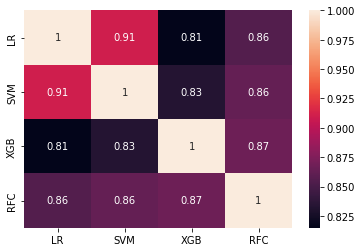

In [52]:
import seaborn as sns
test_Survived_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_SVM = pd.Series(SVMC_best.predict(X_test), name="SVM")
test_Survived_XGB = pd.Series(XGB_best.predict(X_test), name="XGB")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_LR,test_Survived_SVM, test_Survived_XGB, test_Survived_RFC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [53]:
print('test score LR:', gsLR.best_score_)
print('test score RFC:', gsRFC.best_score_)
print('test score SVMC:', gsSVMC.best_score_)
print('test score XGB:', gsXGB.best_score_)

test score LR: 0.8283021223470662
test score RFC: 0.8440199750312111
test score SVMC: 0.8327715355805243
test score XGB: 0.8552684144818976


In [54]:
#here I use the soft rule as voting rule because it produced a better score on Kaggle rather than the hard rule. 
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('LR', LR_best), 
('SVM',SVMC_best), ('XGB',XGB_best), ("RandomForest",RFC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [55]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")

In [56]:
ids = pd.read_csv('test.csv')['PassengerId']

predictions = votingC.predict(X_test)


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
